## Импорты

In [ ]:
import torch
from torch import nn
from torch import optim

from IPython.display import clear_output
import random
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

## Вспомогательный код

Просто запустить

In [ ]:
#@title 
def show_mnist(images, labels, predicted_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {labels[i]}. Pred: {predicted_labels[i]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {labels[i]}")

def show_progress(train_loss, test_loss, train_acc, test_acc):
        clear_output()
        plt.figure(figsize=(13,6))
        plt.subplot(121)
        plt.plot(train_loss, label='Тренировка')
        plt.plot(test_loss, label='Валидация')
        plt.title('Функция потерь')
        plt.xlabel('Эпоха')
        plt.legend()

        plt.subplot(122)
        plt.plot(train_acc, label='Тренировка')
        plt.plot(test_acc, label='Валидация')
        plt.title('Точность')
        plt.xlabel('Эпоха')
        plt.legend()
        plt.show()

## Загрузка данных

In [ ]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

X_train = MNIST_train.data / 255 # нормируем от 0 до 1
y_train = MNIST_train.targets

X_test = MNIST_test.data / 255
y_test = MNIST_test.targets

In [ ]:
X_train.dtype, y_train.dtype

(torch.float32, torch.int64)

#Нужно привести дату к формату работу со сверткой :

In [ ]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [ ]:
X_train_conv = X_train.unsqueeze(1).float()

[батч размерность ( сколько элементов) , кол-во каналов , высота картинки , ширина картинки]

In [ ]:
X_train_conv.shape

torch.Size([60000, 1, 28, 28])

In [ ]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

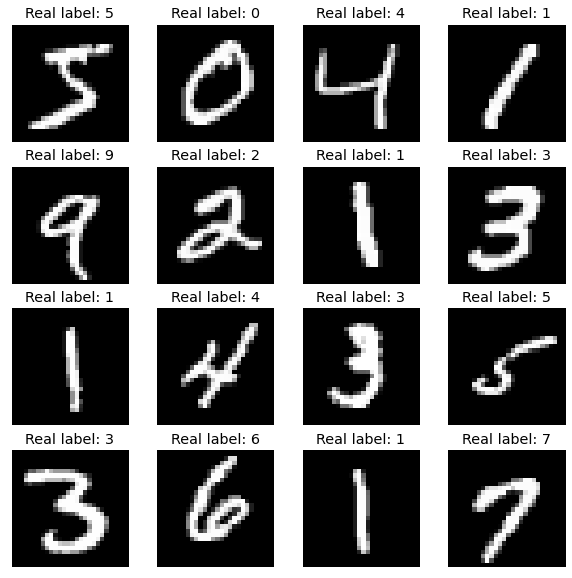

In [ ]:
show_mnist(X_train, y_train)

In [ ]:
X_train_conv.shape

torch.Size([60000, 1, 28, 28])

## Архитектура нейросети

In [ ]:
class MNISTNet(nn.Module):
    def __init__(self, n_hidden_neurons):
        super().__init__()

        self.fc1 = nn.Linear(28 * 28, n_hidden_neurons)
        self.act1 = nn.Sigmoid()
        self.fc2 = nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.act2 = nn.Sigmoid()
        # self.fc3 = nn.Linear(n_hidden_neurons, n_hidden_neurons)
        # self.act3 = nn.Sigmoid()
        self.fc4 = nn.Linear(n_hidden_neurons, 10)
        self.sm = nn.Softmax(dim=1) # правильный ли выход?
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        # и тут не забыть добавить
        x = self.fc2(x)
        x = self.act2(x)
        # x = self.fc3(x)
        # x = self.act3(x)
        x = self.fc4(x)
        x = x.squeeze(1) # ! эту строчку убирать не надо
        return x
    
    def inference(self,x):
      x = self.forward(x)
      x = self.sm(x)
      return x

n_hidden_neurons = 101 # достаточно ли такого числа нейронов?
mnist_net = MNISTNet(n_hidden_neurons)

###Проверим, доступна ли CUDA

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Tue Jun 14 22:11:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

###Параметры нейросети

In [ ]:
list(mnist_net.parameters()) 

[Parameter containing:
 tensor([[ 0.0141,  0.0073,  0.0113,  ..., -0.0128,  0.0338,  0.0266],
         [-0.0137,  0.0339,  0.0329,  ...,  0.0333, -0.0115,  0.0158],
         [-0.0068, -0.0147, -0.0203,  ..., -0.0107,  0.0078, -0.0192],
         ...,
         [ 0.0228, -0.0223,  0.0227,  ..., -0.0111,  0.0094,  0.0245],
         [ 0.0173,  0.0342,  0.0305,  ..., -0.0316,  0.0077,  0.0083],
         [ 0.0319, -0.0083, -0.0105,  ..., -0.0105, -0.0335, -0.0129]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([-0.0018, -0.0257,  0.0083,  0.0219,  0.0007,  0.0073,  0.0061,  0.0092,
         -0.0070, -0.0159,  0.0101,  0.0307, -0.0083, -0.0282, -0.0182,  0.0325,
         -0.0156, -0.0060,  0.0340,  0.0003,  0.0175,  0.0252,  0.0095, -0.0347,
         -0.0091, -0.0301,  0.0111, -0.0042,  0.0180,  0.0001,  0.0117,  0.0036,
         -0.0055,  0.0242, -0.0331,  0.0129,  0.0142,  0.0268,  0.0122, -0.0265,
         -0.0125,  0.0139,  0.0015,  0.0222,  0.0287,  0.0003, 

## Функция потерь и оптимизатор

In [ ]:
lr = 0.00001 # достаточно ли такой скорости обучения?
batch_size = 300 # можно варьировать размер батча (лишь бы влезал в память)
num_epochs = 500 # количество эпох


loss = nn.CrossEntropyLoss() # правильно ли подобрана функция потерь?
optimizer = optim.Adam(mnist_net.parameters(), lr=lr) # можно попробовать другие оптимизаторы

## Цикл обучения

**Внимание! Менять здесь ничего не требуется**

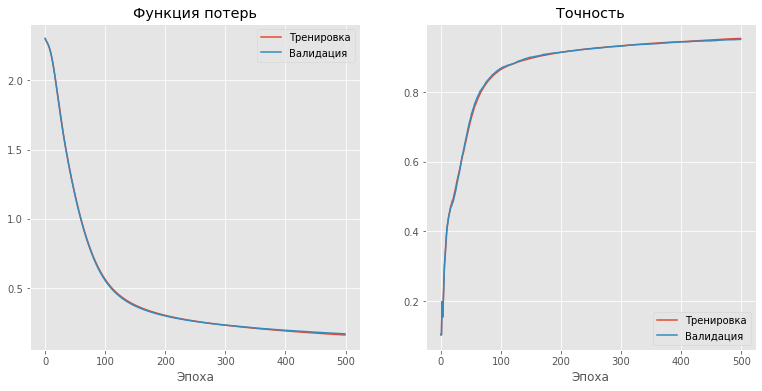

Лучшая точность: 95.13%


In [ ]:
train_accuracy_history = []
train_loss_history = []
test_accuracy_history = []
test_loss_history = []

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        # лосс подсчитывается по-разному, в зависимости от выходов модели
        if preds.ndim == 2 and preds.size(1) == 10:
            loss_value = loss(preds, y_batch)
        else:
            loss_value = loss(preds, y_batch.float())
        loss_value.backward()
        
        optimizer.step()

    with torch.no_grad():
        train_preds = mnist_net.forward(X_train.to(device))
        train_loss_history.append(loss(train_preds, y_train.to(device)).item())
        test_preds = mnist_net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).item())
        
        # предсказания формируются по-разному, в зависимости от выходов модели
        if test_preds.ndim == 2 and test_preds.size(1) == 10:
            predicted_labels_train = train_preds.argmax(dim=1)
            predicted_labels = test_preds.argmax(dim=1)
        else:
            predicted_labels_train = train_preds.int()
            predicted_labels = test_preds.int()
        train_accuracy_history.append((predicted_labels_train == y_train.cuda()).float().mean().item())
        accuracy = (predicted_labels == y_test).float().mean()
        test_accuracy_history.append(accuracy.item())
    if (epoch + 1) % 25 == 0:
        show_progress(train_loss_history, test_loss_history, train_accuracy_history, test_accuracy_history)
        print(f'Лучшая точность: {max(test_accuracy_history):.2%}')

In [ ]:
print('Лучший лосс:', min(test_loss_history))
print(f'Лучшая точность: {max(test_accuracy_history):.2%}')

Лучший лосс: 0.1686696708202362
Лучшая точность: 95.13%


Визуализируем предсказания:

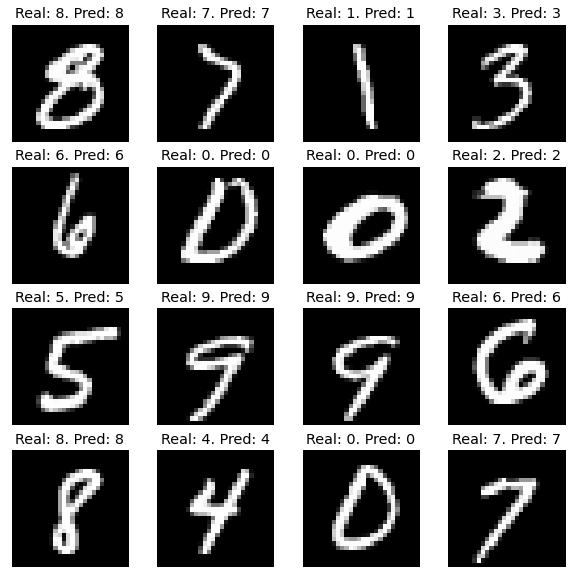

In [ ]:
idxs = np.random.choice(np.arange(len(X_test)), 16, replace=False)
show_mnist(X_test[idxs].reshape((-1, 28, 28)).cpu(), y_test[idxs].cpu(), predicted_labels[idxs].cpu())

##  Вопросы для семинара 

- Что наблюдается во время обучения: недообучение или переобучение?

Запустите обучение с нуля ещё раз (все ячейки) и ответьте на оставшиеся вопросы:
- Одинаковые ли результаты (значения метрик) от запуска к запуску обучения?  Почему?
- Какая задача решается: регрессия или классификация? Почему?
- Правильно ли подобраны архитектура нейросети и функция потерь?



<ПОЛЕ ДЛЯ ОТВЕТА>
1. На примере текущего задания мы можем наблюдать недообучение модели.Во время недообучения: мы видим как  алгоритм обучения не обеспечивает достаточно малой величины средней ошибки на обучающей выборке, что приводит к неточным предсказаниям на валидационной выборке. При переобучении модели появляется другой негативный эффект. Модель как правило является сложной, которая слишком близко или точно соответствуют конкретному набору данных и поэтому не подходит для применения алгоритма к дополнительным данным из валидационной выборки или будущим наблюдениям. 
2.  первоначальные наборы весов инициализируются рандомно , поэтому метрики тоже будут отличаться.
3. Архитектура нейросети , функция лос и оптимизатор подобраны для линейной регрессии. Данная задача должна решаться иначе , используя методы обучения модели  задачи классификации.
4. Нет, не правильно. В задаче классификации после софтмакс функции используется nn.CrossEntropyLoss() , для линейной регрессии подойдет MSE лосс функция.

### Исправление архитектуры нейросети

Исправьте архитектуру нейронной сети, а также функцию потерь, чтобы они соответствовали решаемой задаче машинного обучения. После запустите повторно цикл обучения и ответьте на вопросы:
- Улучшилась ли метрика?
- Почему функция потерь MSE не подходит для решения нашей задачи?


<ПОЛЕ ДЛЯ ОТВЕТА>
1. Метрики улучшились на порядок, точность предсказания выросла после изменения архитектуры сети.
2. MSE лосс функция  используется для линейной регресии , где на выходе в нейронах мы получаем 1 или 0. В задаче классификации в выходном нейроне значения находятся [0;1] ,учитывая что сумма всех выходных нейронов будет равна 1.( после использования софтмакс функции активации.

### Подбор гиперпараметров

Добейтесь точности на валидационной выборке > 95%. Попробуйте изменять скорость обучения, количество слоев, размер батча, количество эпох. Ответьте на вопросы:
- Что вы наблюдаете при увеличении скорости обучения? Уменьшении? Попробуйте объяснить, почему так происходит.
- Как влияет количество слоев на переобучение/недообучение нейросети? Какие вы знаете методы борьбы с переобучением?
- Быстрее ли сходится модель (когда функция потерь перестаёт значимо уменьшаться) при увеличении размера батча? Почему?
- Улучшилось ли качество при увеличении количества эпох?

<ПОЛЕ ДЛЯ ОТВЕТА>
1. Более высокая скорость обучения помогает нейросети делать большие шаги в направлении минимальной ошибки.Это происходит потому что скорость обучения это по сути коэф. корекции весов. Чем меньше число , тем меньше шаг коррекции , тем больше точность нахождения точек локального минимума функции ошибки,но меньше ее скорость нахождения. 

Когда я выставляю высокую скорость обучения модель сильно обучается под тренировочные данные и показывает плохие результаты с валидационной выборкой.
2. Чем больше слоев -- тем сложнее модель , а чем сложнее модель тем она "умнее". Соответственно одним из решений проблемы недообучения является увелечение кол-ва слоев в нейронной сети. Точно также действует и обратное правило , черезмерно сложное строение модели(т.е. большое кол-во слоев) может вызвать переобучение модели. 

Методы борбы с переобучением : 
увелечение размера выборки или батча ,
* уменьшение числа признаков или первоначальное кол-во входных нейронов, 
* уменьшение кол-ва слоев и кол-ва нейронов в каждом их них,
* использования методов регуляризации за счет предотвращения сложных коадаптаций отдельных нейронов на тренировочных данных во время обучения,
* ранняя остановка обучения с момента наступления эпохи переобучения.
3. Чем больше батч ,тем быстрее сходиться модель так требуется меньше итераций за одну эпоху.
4. Да качество сети улучшилось , кол-во эпох влияет на степень обученности модели , чем больше эпох тем лучше результат в точности, однако черезмерно большое кол-во эпох может вызвать переобучение.